In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
from tqdm import tqdm
# from floorplan_utils import *
# from img_utils import *

In [3]:
mpl.rcParams['figure.figsize'] = [15, 15]

# Graph processing

In [4]:
opt_df = pd.read_pickle('./opt_df.pic')

In [5]:
opt_df

wf   gnss_lat  \
step_id                                                                 
1        {'207394925875571': -47, '207394925875570': -4...        NaN   
2                                                     None  55.942823   
3                                                     None        NaN   
4                                                     None        NaN   
5                                                     None        NaN   
...                                                    ...        ...   
106334   {'207394925917588': -83, '207394925917587': -8...        NaN   
106335                                                None        NaN   
106336                                                None        NaN   
106337                                                None        NaN   
106338   {'207394925917588': -85, '207394925917587': -8...        NaN   

         gnss_lon         z     z_raw  is_baro           t          x  \
step_id                                                                 
1             NaN -0.003880  0.000000     True   5455892.0  19.429567   
2        -3.18914 -0.003880  0.000000     True   5455992.0  19.415120   
3             NaN -0.003880  0.000000     True   5456252.0  19.310557   
4             NaN -0.003880  0.000000     True   5456482.0  19.195583   
5             NaN -0.003880  0.000000     True   5456692.0  19.073481   
...           ...       ...       ...      ...         ...        ...   
106334        NaN -0.011057  0.522397     True  11123112.0  16.343454   
106335        NaN -0.011057  0.547007     True  11123832.0  16.132462   
106336        NaN -0.011057  0.553463     True  11124532.0  15.920868   
106337        NaN -0.011057  0.553463     True  11125152.0  15.706710   
106338        NaN -0.011057  0.553463     True  11126092.0  15.362724   

                 y  pdr_vel  ...  traj_id  gnss_easting  gnss_northing  theta  \
step_id                      ...                                                
1        25.583819  0.69723  ...        0           NaN            NaN      0   
2        25.540276  0.74234  ...        0     -8.031963       7.682255      0   
3        25.395203  0.84942  ...        0           NaN            NaN      0   
4        25.262586  0.93122  ...        0           NaN            NaN      0   
5        25.141082  0.99524  ...        0           NaN            NaN      0   
...            ...      ...  ...      ...           ...            ...    ...   
106334   -5.394785  0.27198  ...      193           NaN            NaN      0   
106335   -5.426694  0.27993  ...      193           NaN            NaN      0   
106336   -5.465603  0.30507  ...      193           NaN            NaN      0   
106337   -5.494010  0.33709  ...      193           NaN            NaN      0   
106338   -5.545816  0.34296  ...      193           NaN            NaN      0   

        is_elevation floor_id elevation_height   max_dist        lat       lon  
step_id                                                                         
1              False      0.0              0.0  42.583348  55.942983 -3.188700  
2              False      0.0              0.0  42.583348  55.942983 -3.188700  
3              False      0.0              0.0  42.583348  55.942982 -3.188702  
4              False      0.0              0.0  42.583348  55.942980 -3.188704  
5              False      0.0              0.0  42.583348  55.942979 -3.188706  
...              ...      ...              ...        ...        ...       ...  
106334         False      0.0              0.0  10.426916  55.942705 -3.188749  
106335         False      0.0              0.0  10.426916  55.942705 -3.188753  
106336         False      0.0              0.0  10.426916  55.942704 -3.188756  
106337         False      0.0              0.0  10.426916  55.942704 -3.188760  
106338         False      0.0              0.0  10.426916  55.942704 -3.188765  

[101250 rows x 28 columns]

In [6]:
opt_df['x'].min()

-14.336349469974367

In [7]:
opt_df['x'].max()

23.047132921048554

In [8]:
opt_df['y'].min()

-32.87111300736769

In [9]:
opt_df['y'].max()

29.7023697005688

In [10]:
opt_df['floor_id'].min()

0.0

In [11]:
opt_df['floor_id'].max()

0.0

In [12]:
floor = 0.0
x_min = -35
x_max = 35
y_min = -40
y_max = 35
resolution = 0.1# 0.1 # meters per pixel
# traj_pix = opt_df.copy()
traj_pix = pd.DataFrame()
traj_pix['x_img'] = ((opt_df[opt_df['floor_id']==floor]['x'] - x_min) // resolution).astype(int)
traj_pix['y_img'] = ((y_max - opt_df[opt_df['floor_id']==floor]['y']) // resolution).astype(int)
traj_pix = traj_pix.drop_duplicates(ignore_index=True)

100%|██████████| 49448/49448 [00:02<00:00, 18159.12it/s]


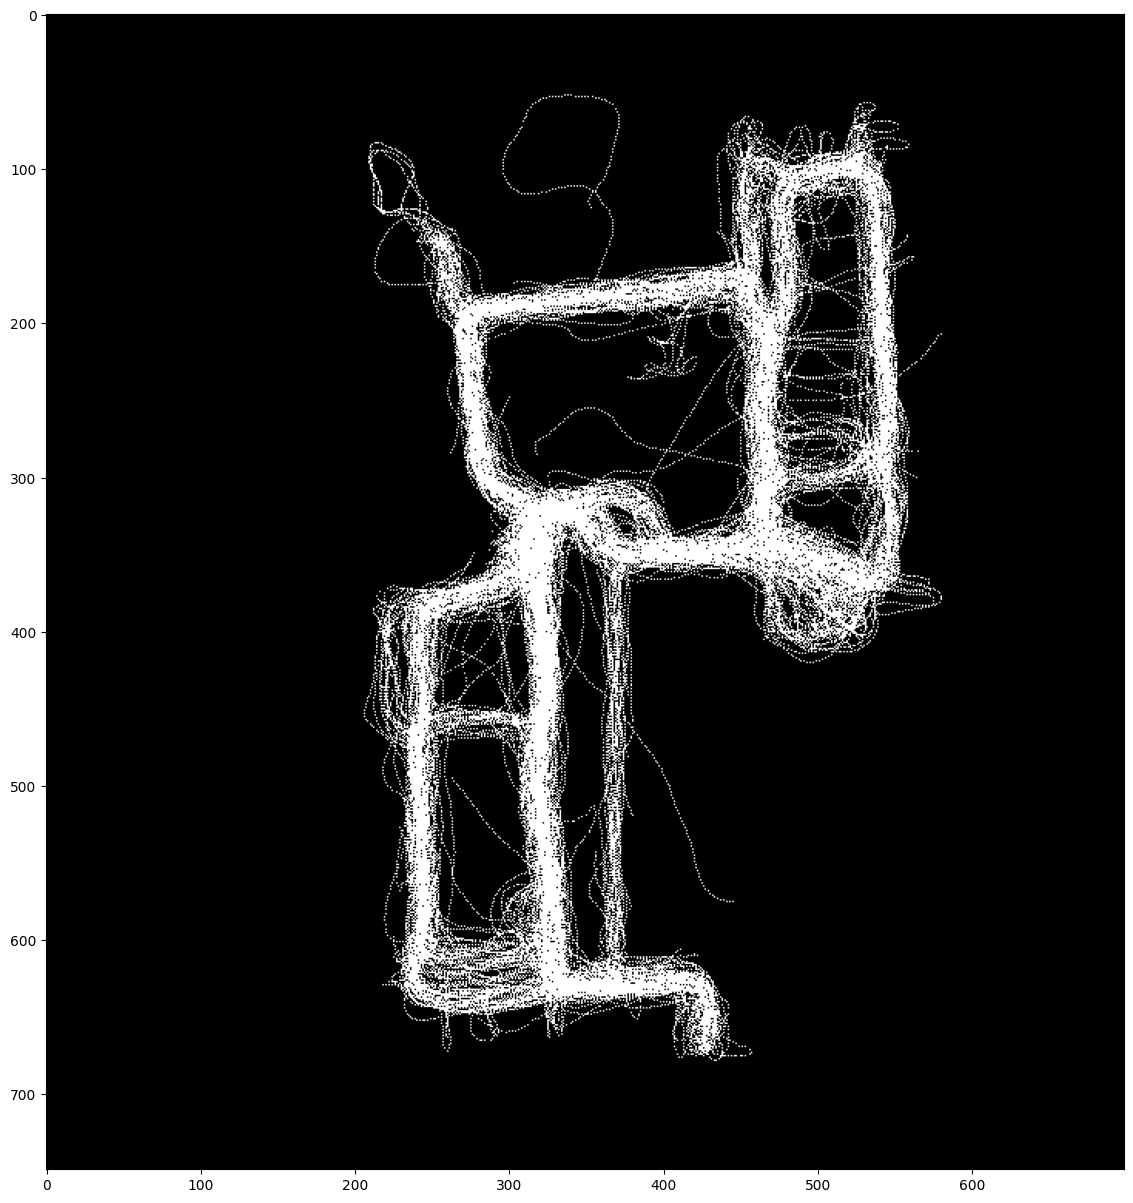

In [13]:
img_size_x = int((x_max - x_min) // resolution)
img_size_y = int((y_max - y_min) // resolution)
traj_img = np.zeros([img_size_y, img_size_x]).astype('uint8')
for i in tqdm(range(len(traj_pix))):
    traj_img[traj_pix.iloc[i,1], traj_pix.iloc[i,0]] = 255
plt.imshow(traj_img, cmap='gray')

In [14]:
traj_img.shape

(749, 699)

In [15]:
im = Image.fromarray(traj_img)
im.save('./radiomap_f1.png')

# Map processing

In [16]:
img_file = './2.png'
# pgw_file = r'C:\Users\p50023028\Documents\data\beijing_shoudu_t2\output\beijing_shoudu_t2_20220609_0302_0430\maps\2\2.pgw'

In [17]:
img = cv.imread(img_file, cv.IMREAD_GRAYSCALE)

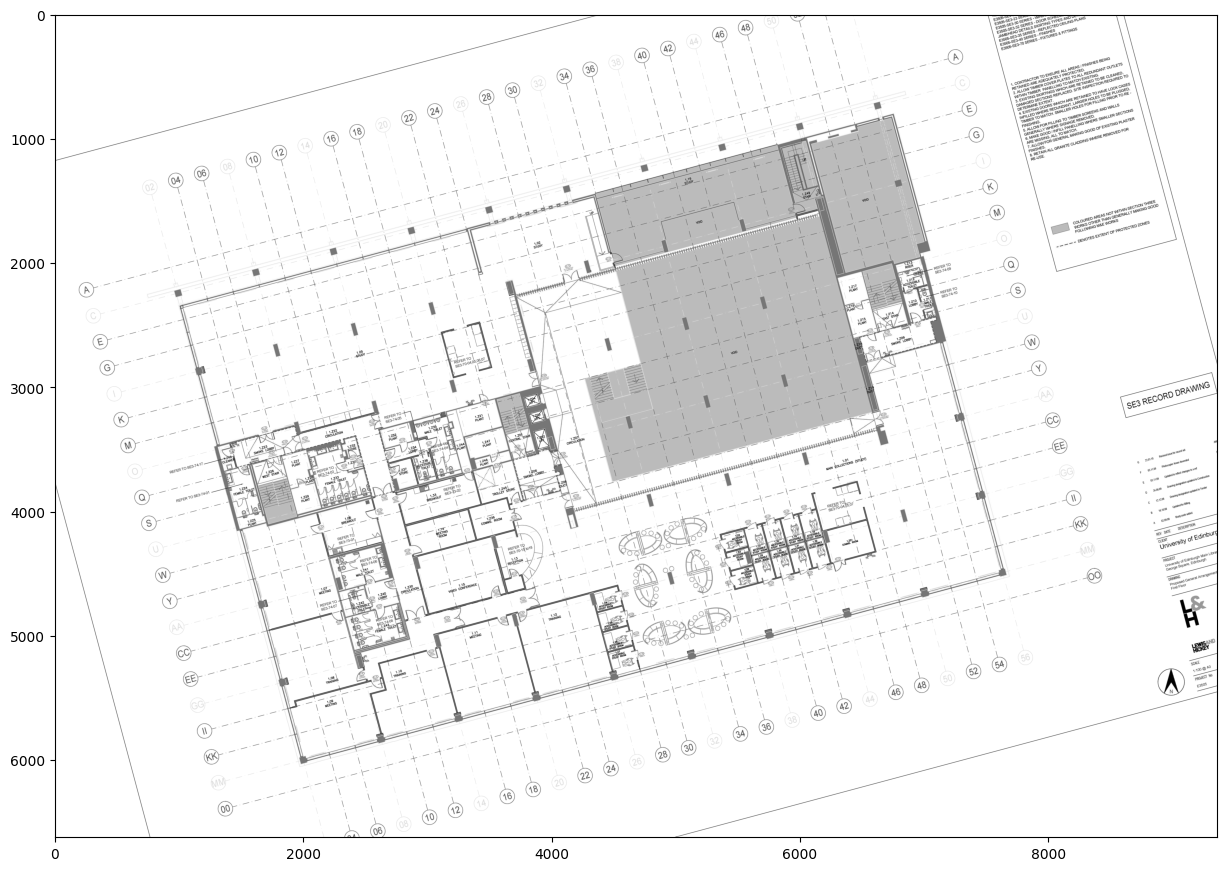

In [18]:
plt.imshow(img, cmap='gray')

In [19]:
img.shape

(6623, 9362)

In [20]:
# np.save('./bayes_radiomap/bayes_f1_map.npy', img)
np.save('./ml_map.npy', img)

# Load manually selected feature points

Read points and flip from (x, y) to (y, x)

In [21]:
# traj_gt = np.array([[337, 70],
#                     [238, 132],
#                     [276, 203],
#                     [443, 122],
#                     [556, 375],
#                     [458, 435],
# #                     [278, 600]
#                    ])
# map_gt = np.array([[588, 803],
#                    [661, 1122],
#                    [913, 1045],
#                    [770, 476],
#                    [1610, 260],
#                    [1767, 618],
# #                    [2170, 1533]
#                   ])
traj_gt = np.array(
    [
        [426.9,672.5],
        [418.8,627.1],
        [368.68,617.49],
        [255.5,143.2],
    ]
)
map_gt = np.array(
    [
        [7050,2549],
        [6591,2772],
        [6621,3248],
        [2552,5117],
    ]
)
traj_gt = np.flip(traj_gt, axis=1)
map_gt = np.flip(map_gt, axis=1)

In [22]:
print(map_gt.shape)
print(traj_gt.shape)

(4, 2)
(4, 2)


In [23]:
map_gt

array([[2549, 7050],
       [2772, 6591],
       [3248, 6621],
       [5117, 2552]])

In [24]:
traj_gt

array([[672.5 , 426.9 ],
       [627.1 , 418.8 ],
       [617.49, 368.68],
       [143.2 , 255.5 ]])

# Load images

```map_img``` and ```traj_img``` contains matching points (x, y) in IMAGE COORDINATES.

In [25]:
# map_img = np.load('./bayes_radiomap/bayes_f1_map.npy')
map_img = np.load("ml_map.npy")
# traj_img = np.load('forum_f0_traj.npy')

In [26]:
print(map_img.shape)
print(traj_img.shape)

(6623, 9362)
(749, 699)


# Interpolate

The ```grid``` is in (y, x) sequence, as in usual numpy definition.

In [27]:
WIDTH = 9362
HEIGHT = 6623
dim = (WIDTH, HEIGHT)

In [28]:
grid = np.mgrid[0:HEIGHT, 0:WIDTH]
grid_flat = grid.reshape(2, -1).T

Data point coordinates: ```map_gt```

Interpolation target values: ```traj_gt```

Data grid of map coordinates: ```grid_flat```

Resulting grid of interpolated trajectory coordinates: ```grid_z_rbf```

In [29]:
grid_z_rbf = RBFInterpolator(map_gt, traj_gt)(grid_flat)
grid_z_rbf_reshape = grid_z_rbf.reshape(HEIGHT, WIDTH, 2)

The resulting interpolation is in (y, x) sequence.

# Warp image

In [30]:
map_x = np.append([], [ar[:,1] for ar in grid_z_rbf_reshape]).reshape(HEIGHT, WIDTH)
map_y = np.append([], [ar[:,0] for ar in grid_z_rbf_reshape]).reshape(HEIGHT, WIDTH)
map_x_32 = map_x.astype('float32')
map_y_32 = map_y.astype('float32')

```remap()``` takes a vector field where each vector points to the pixel of the source image.

```map_x_32``` and ```map_y_32``` describes the vector field. They are in the same shape of the image, aka, HxW.

Or else, the vector field can also be described by a 3D HxWx2 shape array. 

The pixel values are stored in ```traj_img```. ```map_x_32``` and ```map_y_32``` tells the algorithm where to fetch the pixel value in ```traj_img``` in order to fill the warped image.

In [31]:
warped_image = cv.remap(traj_img, map_x_32, map_y_32, cv.INTER_CUBIC)

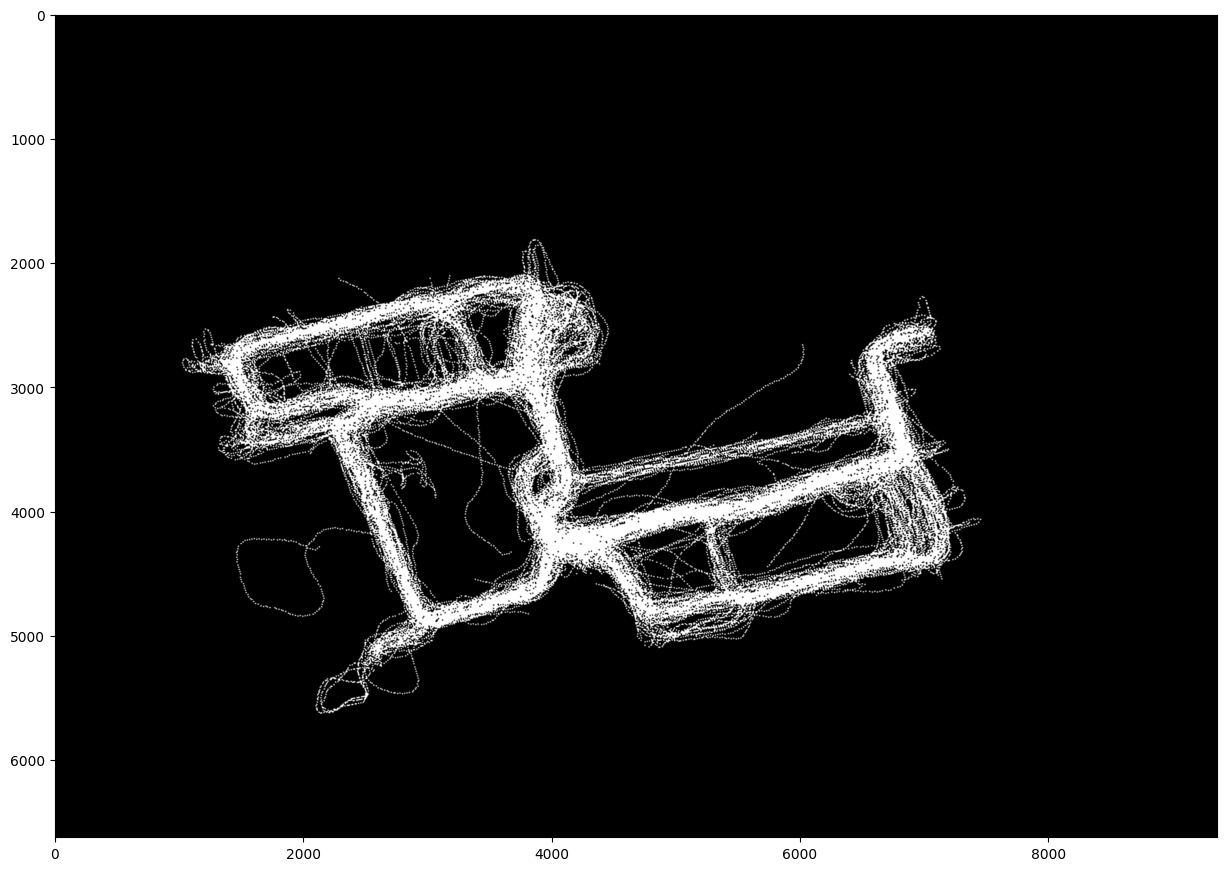

In [33]:
plt.imshow(warped_image, cmap='gray')

# Overlay images

In [34]:
warped_flip = (map_img - warped_image).astype('int')

In [35]:
viz = np.stack((map_img, warped_flip, warped_flip), axis=2)

In [36]:
map_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Text(0, 0.5, 'Y (North)')

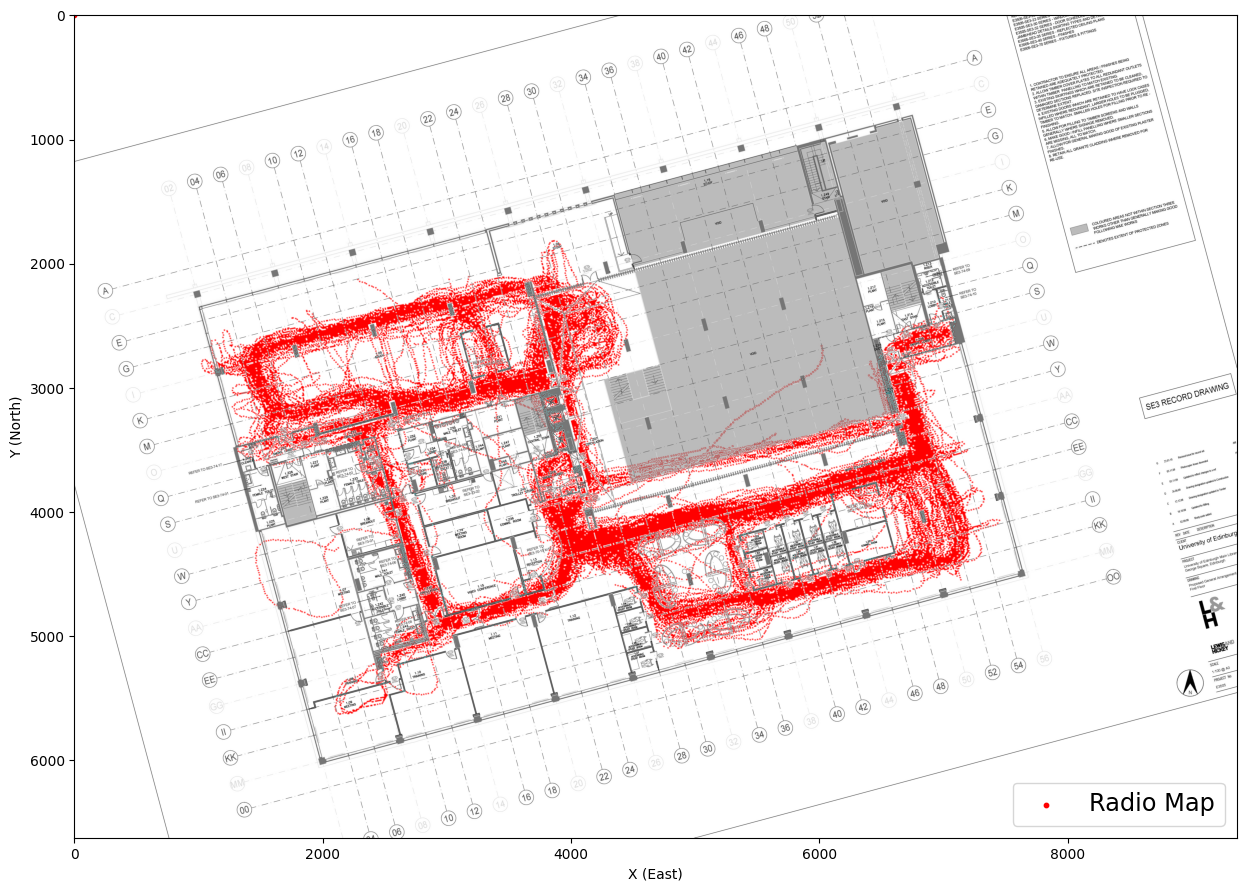

In [37]:
plt.imshow(viz)
plt.scatter(0, 0, label='Radio Map', c='r', s=10)
plt.legend(loc=4, fontsize='xx-large')
plt.xlabel('X (East)')
plt.ylabel('Y (North)')

# Apply to whole graph

In order to get the Lat Long value of the whole graph, the reverse of the above interpolation needs to be used:

Rather than mapping the graph to the floor plan, we need to map the floor plan to the graph.

In [38]:
floor = 0.0
x_min = -35
x_max = 35
y_min = -40
y_max = 35
resolution = 1.0 # meters per pixel
# traj_pix = opt_df.copy()
traj_pix = pd.DataFrame()
traj_pix['x_img'] = ((opt_df[opt_df['floor_id']==floor]['x'] - x_min) / resolution)
traj_pix['y_img'] = ((y_max - opt_df[opt_df['floor_id']==floor]['y']) / resolution)
traj_pix['wf'] = opt_df[opt_df['floor_id']==floor]['wf']
traj_pix['t'] = opt_df[opt_df['floor_id']==floor]['t']
traj_pix['orig_step_id'] = opt_df[opt_df['floor_id']==floor]['orig_step_id']
traj_pix['step_id'] = opt_df[opt_df['floor_id']==floor]['step_id']
traj_pix['traj_id'] = opt_df[opt_df['floor_id']==floor]['traj_id']
traj_pix['pdr_vel'] = opt_df[opt_df['floor_id']==floor]['pdr_vel']
traj_pix['pdr_head'] = opt_df[opt_df['floor_id']==floor]['pdr_head']
traj_pix['pdr_dist'] = opt_df[opt_df['floor_id']==floor]['pdr_dist']
traj_pix['pdr_still'] = opt_df[opt_df['floor_id']==floor]['pdr_still']
traj_pix['theta'] = opt_df[opt_df['floor_id']==floor]['theta']

In [ ]:
# traj_pix = traj_pix.dropna()

In [39]:
traj_pix

x_img      y_img  \
step_id                         
1        54.429567   9.416181   
2        54.415120   9.459724   
3        54.310557   9.604797   
4        54.195583   9.737414   
5        54.073481   9.858918   
...            ...        ...   
106334   51.343454  40.394785   
106335   51.132462  40.426694   
106336   50.920868  40.465603   
106337   50.706710  40.494010   
106338   50.362724  40.545816   

                                                        wf           t  \
step_id                                                                  
1        {'207394925875571': -47, '207394925875570': -4...   5455892.0   
2                                                     None   5455992.0   
3                                                     None   5456252.0   
4                                                     None   5456482.0   
5                                                     None   5456692.0   
...                                                    ...         ...   
106334   {'207394925917588': -83, '207394925917587': -8...  11123112.0   
106335                                                None  11123832.0   
106336                                                None  11124532.0   
106337                                                None  11125152.0   
106338   {'207394925917588': -85, '207394925917587': -8...  11126092.0   

         orig_step_id  step_id  traj_id  pdr_vel    pdr_head  pdr_dist  \
step_id                                                                  
1                  52        1        0  0.69723   -40.24670   0.29775   
2                  62        2        0  0.74234   -45.32307   0.36997   
3                  88        3        0  0.84942   -59.94103   0.57777   
4                 111        4        0  0.93122   -76.65261   0.78318   
5                 132        5        0  0.99524   -98.87515   0.98596   
...               ...      ...      ...      ...         ...       ...   
106334          11465   106334      193  0.27198   341.73926  43.82828   
106335          11537   106335      193  0.27993  -358.01536  44.02808   
106336          11607   106336      193  0.30507 -2622.52873  44.22974   
106337          11669   106337      193  0.33709   582.13406  44.43205   
106338          11763   106338      193  0.34296 -1144.43758  44.76629   

         pdr_still  theta  
step_id                    
1            False      0  
2            False      0  
3            False      0  
4            False      0  
5            False      0  
...            ...    ...  
106334       False      0  
106335       False      0  
106336       False      0  
106337       False      0  
106338       False      0  

[101250 rows x 12 columns]

In [40]:
# traj_gt = np.array([[337, 70],
#                     [238, 132],
#                     [276, 203],
#                     [443, 122],
#                     [556, 375],
#                     [458, 435],
# #                     [278, 600]
#                    ])
# map_gt = np.array([[588, 803],
#                    [661, 1122],
#                    [913, 1045],
#                    [770, 476],
#                    [1610, 260],
#                    [1767, 618],
# #                    [2170, 1533]
#                   ])

traj_gt = np.array(
    [
        [426.9,672.5],
        [418.8,627.1],
        [368.68,617.49],
        [255.5,143.2],
    ]
)
map_gt = np.array(
    [
        [7050,2549],
        [6591,2772],
        [6621,3248],
        [2552,5117],
    ]
)
traj_gt = np.flip(traj_gt, axis=1)
map_gt = np.flip(map_gt, axis=1)
traj_gt = traj_gt / 10
map_gt = map_gt  / 72 / 39.37 * 100



```map_gt``` stores (y, x) in image coordinates, in meters.

```y``` needs to be the opposite for ENU coordinates.

In [41]:
map_gt_enu = map_gt.copy()
map_gt_enu[:, 0] = -map_gt_enu[:, 0] 

Translate to wgs

In [42]:
# map_gt_wgs = []
# for y, x in map_gt_enu:
#     wgs = enu_to_wgs(x, y, pgw)
#     map_gt_wgs.append(wgs)
# map_gt_wgs = np.array(map_gt_wgs)

Method 1: Interpolate map points based on graph grid.

In [43]:
# grid = np.mgrid[0:1000, 0:500]
# grid_flat = grid.reshape(2, -1).T
# grid_z = RBFInterpolator(traj_gt, map_gt_wgs)(grid_flat)

In [44]:
np.mgrid[0:70:0.1, 0:70]

array([[[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        ...,
        [69.7, 69.7, 69.7, ..., 69.7, 69.7, 69.7],
        [69.8, 69.8, 69.8, ..., 69.8, 69.8, 69.8],
        [69.9, 69.9, 69.9, ..., 69.9, 69.9, 69.9]],

       [[ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        ...,
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ]]])

In [45]:
grid = np.mgrid[0:70:0.1, 0:70:0.1]
grid_flat = grid.reshape(2, -1).T
grid_z = RBFInterpolator(traj_gt, map_gt_enu)(grid_flat)

In [46]:
def find_nearest(array, value):
    idx = (np.linalg.norm(array - value, axis=1)).argmin()
    return idx

In [47]:
graph_wgs = []
for i in tqdm(range(traj_pix.shape[0])):
    value = np.array([traj_pix['y_img'].iloc[i], traj_pix['x_img'].iloc[i]])
    idx = find_nearest(grid_flat, value)
    graph_wgs.append(grid_z[idx])
graph_wgs = np.array(graph_wgs)

100%|██████████| 101250/101250 [20:17<00:00, 83.18it/s]


In [48]:
traj_pix['x_meter'] = graph_wgs[:, 1].copy()
traj_pix['y_meter'] = graph_wgs[:, 0].copy()

In [49]:
traj_pix.to_pickle('./ml_f1_matched_radiomap_all.pic')

In [50]:
traj_pix

x_img      y_img  \
step_id                         
1        54.429567   9.416181   
2        54.415120   9.459724   
3        54.310557   9.604797   
4        54.195583   9.737414   
5        54.073481   9.858918   
...            ...        ...   
106334   51.343454  40.394785   
106335   51.132462  40.426694   
106336   50.920868  40.465603   
106337   50.706710  40.494010   
106338   50.362724  40.545816   

                                                        wf           t  \
step_id                                                                  
1        {'207394925875571': -47, '207394925875570': -4...   5455892.0   
2                                                     None   5455992.0   
3                                                     None   5456252.0   
4                                                     None   5456482.0   
5                                                     None   5456692.0   
...                                                    ...         ...   
106334   {'207394925917588': -83, '207394925917587': -8...  11123112.0   
106335                                                None  11123832.0   
106336                                                None  11124532.0   
106337                                                None  11125152.0   
106338   {'207394925917588': -85, '207394925917587': -8...  11126092.0   

         orig_step_id  step_id  traj_id  pdr_vel    pdr_head  pdr_dist  \
step_id                                                                  
1                  52        1        0  0.69723   -40.24670   0.29775   
2                  62        2        0  0.74234   -45.32307   0.36997   
3                  88        3        0  0.84942   -59.94103   0.57777   
4                 111        4        0  0.93122   -76.65261   0.78318   
5                 132        5        0  0.99524   -98.87515   0.98596   
...               ...      ...      ...      ...         ...       ...   
106334          11465   106334      193  0.27198   341.73926  43.82828   
106335          11537   106335      193  0.27993  -358.01536  44.02808   
106336          11607   106336      193  0.30507 -2622.52873  44.22974   
106337          11669   106337      193  0.33709   582.13406  44.43205   
106338          11763   106338      193  0.34296 -1144.43758  44.76629   

         pdr_still  theta     x_meter    y_meter  
step_id                                           
1            False      0   45.861332 -95.121764  
2            False      0   46.185661 -95.057802  
3            False      0   46.605697 -95.303021  
4            False      0   47.025716 -95.548259  
5            False      0   47.769953 -95.729658  
...            ...    ...         ...        ...  
106334       False      0  149.160004 -85.108619  
106335       False      0  149.335333 -85.744612  
106336       False      0  149.837972 -86.313374  
106337       False      0  150.013501 -86.949148  
106338       False      0  150.277072 -87.902504  

[101250 rows x 14 columns]

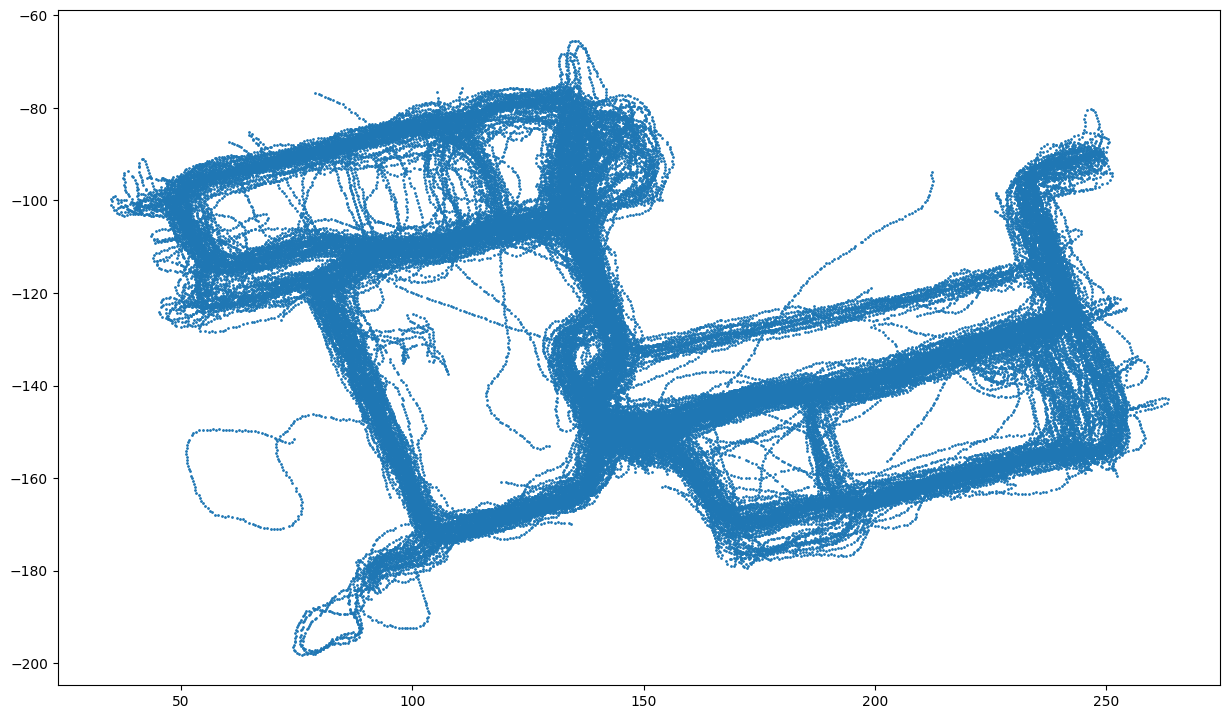

In [51]:
plt.scatter(traj_pix['x_meter'], traj_pix['y_meter'], s=1)
plt.gca().set_aspect('equal', adjustable='box')

In [52]:
warped_flip = (map_img - warped_image).astype('int')

No handles with labels found to put in legend.


Text(0, 0.5, 'Y (North)')

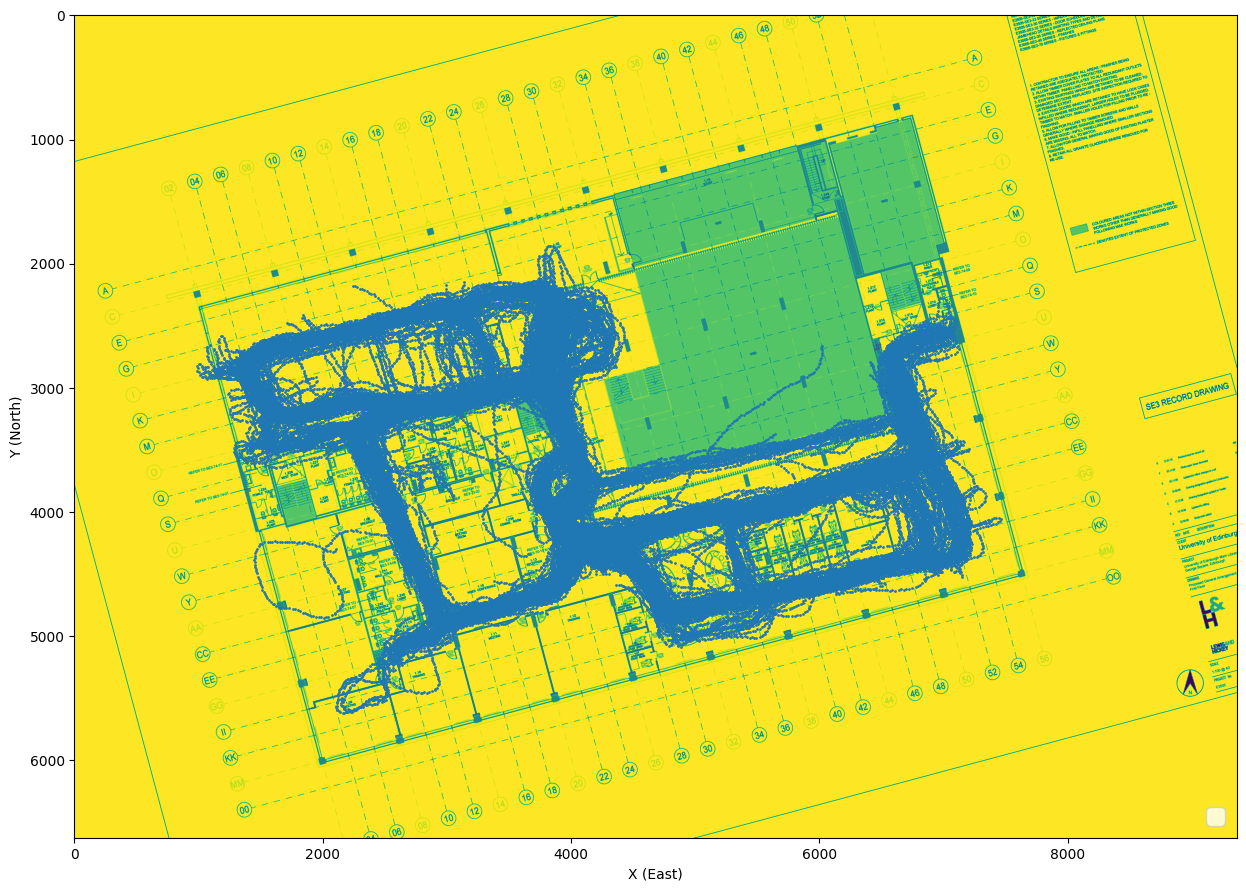

In [53]:
plt.imshow(map_img)
plt.scatter(traj_pix['x_meter'] / 100 * 39.37 * 72, -traj_pix['y_meter'] / 100 * 39.37 * 72, s=1)
plt.legend(loc=4, fontsize='xx-large')
plt.xlabel('X (East)')
plt.ylabel('Y (North)')

In [56]:
# opt_df = pd.read_pickle('./bayes_radiomap/bayes_f1_matched_radiomap.pic')

opt_df = pd.read_pickle('./ml_f1_matched_radiomap_all.pic')

In [57]:
opt_df

x_img      y_img  \
step_id                         
1        54.429567   9.416181   
2        54.415120   9.459724   
3        54.310557   9.604797   
4        54.195583   9.737414   
5        54.073481   9.858918   
...            ...        ...   
106334   51.343454  40.394785   
106335   51.132462  40.426694   
106336   50.920868  40.465603   
106337   50.706710  40.494010   
106338   50.362724  40.545816   

                                                        wf           t  \
step_id                                                                  
1        {'207394925875571': -47, '207394925875570': -4...   5455892.0   
2                                                     None   5455992.0   
3                                                     None   5456252.0   
4                                                     None   5456482.0   
5                                                     None   5456692.0   
...                                                    ...         ...   
106334   {'207394925917588': -83, '207394925917587': -8...  11123112.0   
106335                                                None  11123832.0   
106336                                                None  11124532.0   
106337                                                None  11125152.0   
106338   {'207394925917588': -85, '207394925917587': -8...  11126092.0   

         orig_step_id  step_id  traj_id  pdr_vel    pdr_head  pdr_dist  \
step_id                                                                  
1                  52        1        0  0.69723   -40.24670   0.29775   
2                  62        2        0  0.74234   -45.32307   0.36997   
3                  88        3        0  0.84942   -59.94103   0.57777   
4                 111        4        0  0.93122   -76.65261   0.78318   
5                 132        5        0  0.99524   -98.87515   0.98596   
...               ...      ...      ...      ...         ...       ...   
106334          11465   106334      193  0.27198   341.73926  43.82828   
106335          11537   106335      193  0.27993  -358.01536  44.02808   
106336          11607   106336      193  0.30507 -2622.52873  44.22974   
106337          11669   106337      193  0.33709   582.13406  44.43205   
106338          11763   106338      193  0.34296 -1144.43758  44.76629   

         pdr_still  theta     x_meter    y_meter  
step_id                                           
1            False      0   45.861332 -95.121764  
2            False      0   46.185661 -95.057802  
3            False      0   46.605697 -95.303021  
4            False      0   47.025716 -95.548259  
5            False      0   47.769953 -95.729658  
...            ...    ...         ...        ...  
106334       False      0  149.160004 -85.108619  
106335       False      0  149.335333 -85.744612  
106336       False      0  149.837972 -86.313374  
106337       False      0  150.013501 -86.949148  
106338       False      0  150.277072 -87.902504  

[101250 rows x 14 columns]

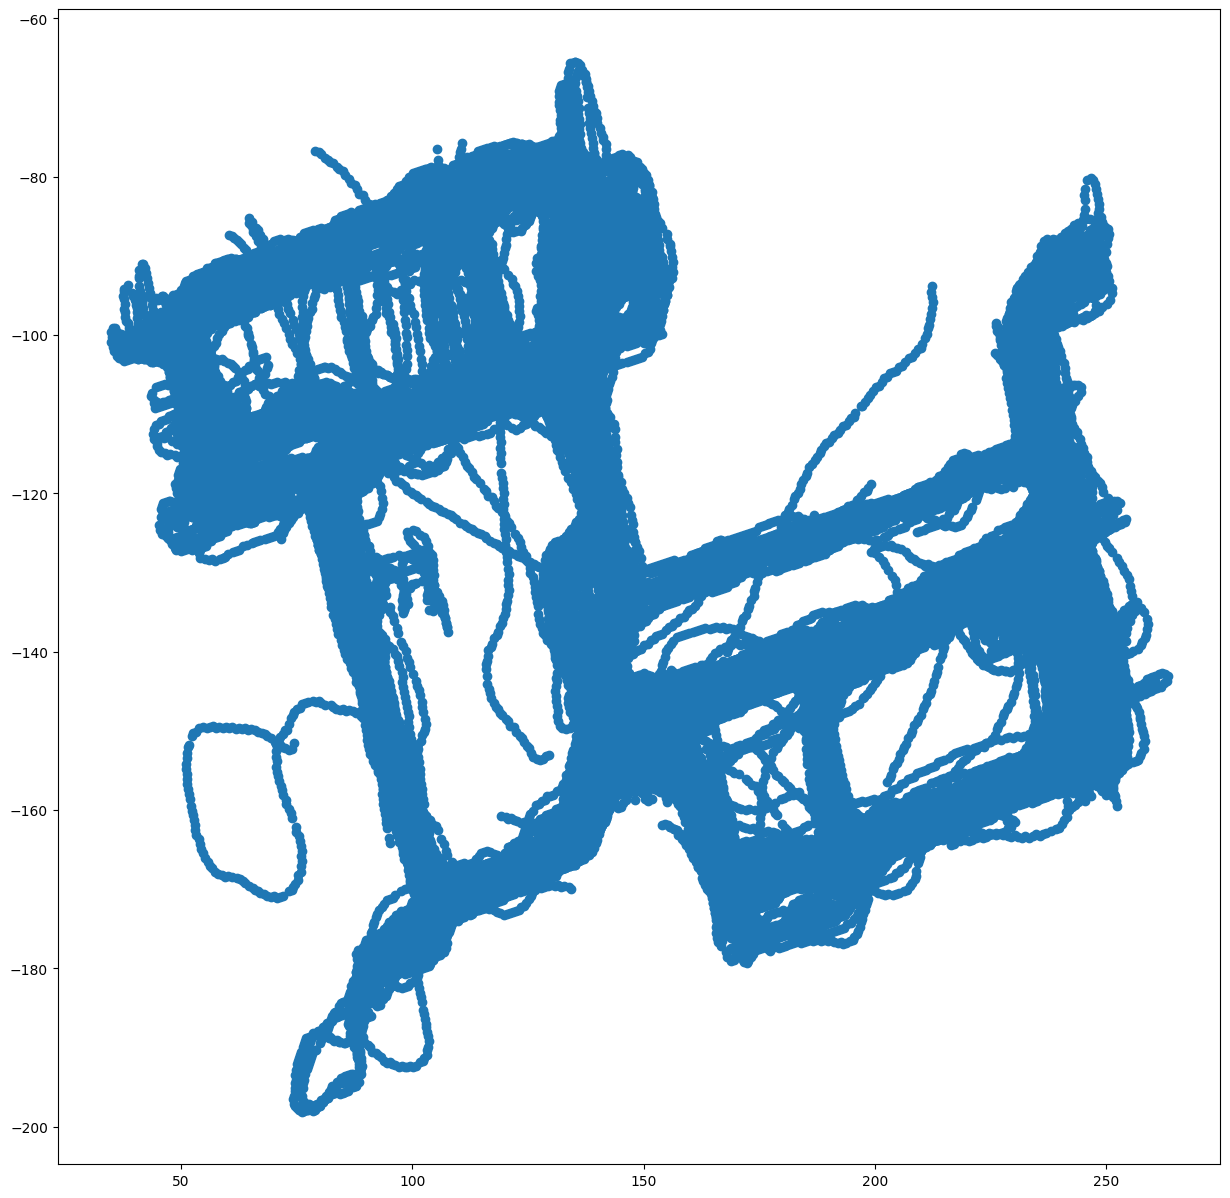

In [58]:
plt.scatter(opt_df.x_meter, opt_df.y_meter)

In [59]:
plt.scatter(opt_df.x_, opt_df.y_meter)

AttributeError: 'DataFrame' object has no attribute 'x_'